# RQ1: 다이소 뷰티에서 재구매를 만드는 핵심 속성은 무엇인가?

**연구 질문:**
- 다이소의 핵심 경쟁력은 가격이 아니다
- '싸서 한번 사는 시장'이 아니라 '품질이 괜찮아서 계속 쓰는 시장'이 되어야 한다

**분석 목표:**
- 재구매 그룹과 일반 그룹의 리뷰 키워드 비교
- '가성비' vs '품질/심미' 키워드 비율 분석
- 물류 불만과 제품 품질 불만 분리 분석

**선행 연구:**
- 논문 1: 품질, 디자인, 편의성이 재구매에 영향 (가격, 브랜드는 영향 없음)
- 논문 4: 소비자는 '꾸준하다'는 표현 사용 (지속 사용 만족도)

---

## 1. 환경 설정

In [2]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 유틸리티 모듈 import
import sys
sys.path.append('./utils')
from text_preprocessing import extract_repurchase_flag, preprocess_text, tokenize_reviews
from keyword_analysis import (calculate_keyword_frequency, compare_keyword_groups,
                               calculate_category_frequency_for_reviews, calculate_category_ratio,
                               KEYWORD_CATEGORIES)
from visualization import (create_wordcloud, plot_keyword_comparison, plot_category_comparison,
                           create_comparison_wordclouds, plot_grouped_bar, plot_rating_distribution)

In [3]:
import matplotlib.pyplot as plt

# 스타일 및 한글 폰트 설정
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'Noto Sans KR'
plt.rcParams['axes.unicode_minus'] = False

print(f"설정 완료: {plt.rcParams['font.family']}")

설정 완료: ['Noto Sans KR']


## 2. 데이터 로드

In [4]:
# 리뷰 데이터 로드
df_reviews = pd.read_parquet('../data/reviews.parquet')

print(f"[데이터 로드 완료]")
print(f"총 리뷰 수: {len(df_reviews):,}개")
print(f"컬럼: {df_reviews.columns.tolist()}")
print(f"\n[샘플 데이터]")
df_reviews.head()

[데이터 로드 완료]
총 리뷰 수: 200,404개
컬럼: ['product_code', 'date', 'user_masked', 'rating', 'text', 'image_count', 'user_id', 'order_id']

[샘플 데이터]


,product_code,date,user_masked,rating,text,image_count,user_id,order_id
0,1025659,2020-10-21,aro********,5,가성비 및 품질이 좋아 구매합니다.\n잘 부러지지 않고 가격대비 수량도 많아 추천합니다.,0,5672,1
1,1007503,2020-11-26,zin*****,5,재구매 양도 많은데 깔끔한 보관통까지... 항상 가성비와 가심비에 놀라고 있습니다.,0,2447,2
2,1018260,2021-01-04,myk******,5,잘쓰고 있습니다\n물건은 안전하게 잘받았습니다,0,2354,3
3,58703,2021-01-21,sun******,5,알로에가 들어있어서 시원하구요\n향기도 좋습니다.\n손발 머리 온몸에 발라서 건조함...,0,36,4
4,1018260,2021-01-29,oot***,5,저렴하고 품질도 좋아서 면봉은 다이소만 구매합니다 좋네요,0,8010,5


In [5]:
# 기본 통계
print("[리뷰 데이터 기본 통계]")
print(f"평균 평점: {df_reviews['rating'].mean():.2f}")
print(f"리뷰 기간: {df_reviews['date'].min()} ~ {df_reviews['date'].max()}")
print(f"고유 제품 수: {df_reviews['product_code'].nunique():,}개")
print(f"고유 사용자 수: {df_reviews['user_id'].nunique():,}명")

[리뷰 데이터 기본 통계]
평균 평점: 4.78
리뷰 기간: 2020-10-21 00:00:00 ~ 2026-01-29 00:00:00
고유 제품 수: 337개
고유 사용자 수: 22,631명


## 3. 재구매 여부 식별

In [6]:
# 재구매 플래그 추출
df_reviews['is_재구매'] = df_reviews['text'].apply(extract_repurchase_flag)

# 재구매 비율 확인
repurchase_counts = df_reviews['is_재구매'].value_counts()
repurchase_rate = (repurchase_counts[True] / len(df_reviews) * 100) if True in repurchase_counts else 0

print(f"[재구매 여부 식별 완료]")
print(f"재구매 리뷰: {repurchase_counts.get(True, 0):,}개 ({repurchase_rate:.1f}%)")
print(f"일반 리뷰: {repurchase_counts.get(False, 0):,}개 ({100-repurchase_rate:.1f}%)")

[재구매 여부 식별 완료]
재구매 리뷰: 68,315개 (34.1%)
일반 리뷰: 132,089개 (65.9%)


In [7]:
# 재구매 리뷰 샘플 확인
print("[재구매 리뷰 샘플]")
repurchase_samples = df_reviews[df_reviews['is_재구매']]['text'].head(10)
for idx, text in enumerate(repurchase_samples, 1):
    print(f"{idx}. {text[:100]}")

[재구매 리뷰 샘플]
1. 재구매 양도 많은데 깔끔한 보관통까지... 항상 가성비와 가심비에 놀라고 있습니다.
2. 재구매 파우더쓸때 좋아요요
3. 재구매 선크림 바를때 잘 쓰는 제품입니다. 스펀지가 흐물흐물하지 않아서 좋아요.
4. 재구매 저렴한가격에 구매했어요
5. 재구매 갯수많고 가격은 저렴해서 가성비는 최고에요. 대신 잘 부러지는 면봉도 꽤 들어있어요ㅠ
6. 재구매 잘사용하고있어여...
7. 재구매 한달이면이거다써서맨날사여
8. 재구매 가격저렴하고양도많고사용하기편하네여..
9. 재구매 잘 사용하고 있어요~
10. 재구매 늘 쓰던거! 잘쓰겠습니다~


## 4. 그룹별 기본 통계 비교

In [8]:
# 재구매 그룹과 일반 그룹 분리
df_repurchase = df_reviews[df_reviews['is_재구매']].copy()
df_general = df_reviews[~df_reviews['is_재구매']].copy()

print("[그룹 분리 완료]")
print(f"재구매 그룹: {len(df_repurchase):,}개")
print(f"일반 그룹: {len(df_general):,}개")

[그룹 분리 완료]
재구매 그룹: 68,315개
일반 그룹: 132,089개


In [9]:
# 그룹별 평점 비교
print("[그룹별 평점 비교]")
print(f"재구매 그룹 평균 평점: {df_repurchase['rating'].mean():.2f}")
print(f"일반 그룹 평균 평점: {df_general['rating'].mean():.2f}")

# 리뷰 길이 비교
df_reviews['text_length'] = df_reviews['text'].str.len()
print(f"\n[그룹별 리뷰 길이 비교]")
print(f"재구매 그룹 평균 길이: {df_reviews[df_reviews['is_재구매']]['text_length'].mean():.0f}자")
print(f"일반 그룹 평균 길이: {df_reviews[~df_reviews['is_재구매']]['text_length'].mean():.0f}자")

# 이미지 포함 비율
print(f"\n[그룹별 이미지 포함 비율]")
print(f"재구매 그룹: {(df_repurchase['image_count'] > 0).mean() * 100:.1f}%")
print(f"일반 그룹: {(df_general['image_count'] > 0).mean() * 100:.1f}%")

[그룹별 평점 비교]
재구매 그룹 평균 평점: 4.84
일반 그룹 평균 평점: 4.75

[그룹별 리뷰 길이 비교]
재구매 그룹 평균 길이: 37자
일반 그룹 평균 길이: 34자

[그룹별 이미지 포함 비율]
재구매 그룹: 49.2%
일반 그룹: 48.8%


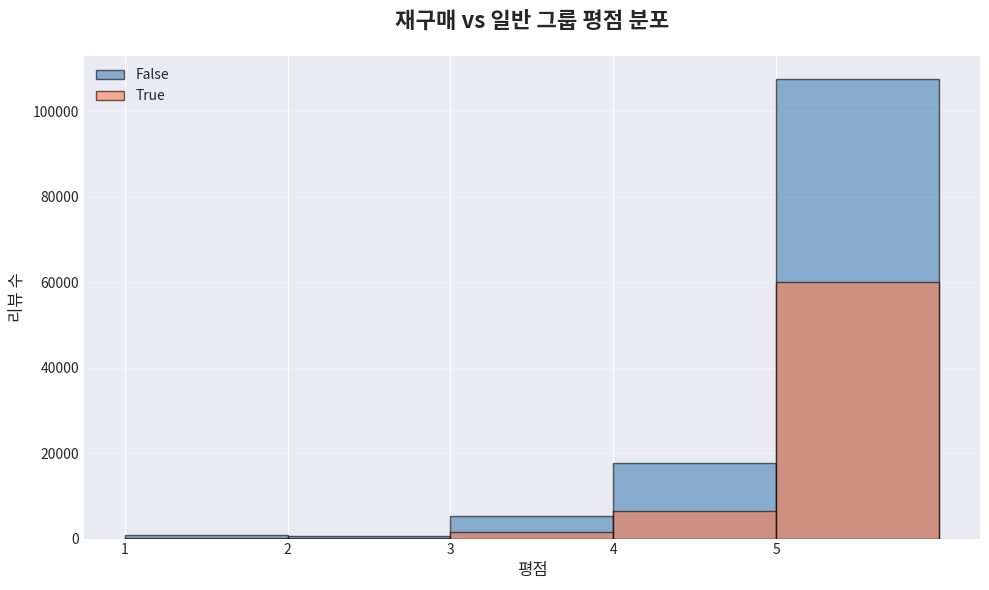

In [10]:
# 그룹별 평점 분포
plot_rating_distribution(
    df_reviews,
    rating_col='rating',
    group_col='is_재구매',
    title='재구매 vs 일반 그룹 평점 분포'
)

## 5. 텍스트 전처리 및 토큰화

In [11]:
# 텍스트 토큰화
print("[텍스트 토큰화 시작]")

df_reviews['tokens'] = tokenize_reviews(
    df_reviews['text'].tolist(),
    extract_pos=['Noun', 'Adjective'],
    remove_stop=True,
    verbose=True
)

print("\n토큰화 완료")

[텍스트 토큰화 시작]
진행중: 1000/200404 (0.5%)
진행중: 2000/200404 (1.0%)
진행중: 3000/200404 (1.5%)
진행중: 4000/200404 (2.0%)
진행중: 5000/200404 (2.5%)
진행중: 6000/200404 (3.0%)
진행중: 7000/200404 (3.5%)
진행중: 8000/200404 (4.0%)
진행중: 9000/200404 (4.5%)
진행중: 10000/200404 (5.0%)
진행중: 11000/200404 (5.5%)
진행중: 12000/200404 (6.0%)
진행중: 13000/200404 (6.5%)
진행중: 14000/200404 (7.0%)
진행중: 15000/200404 (7.5%)
진행중: 16000/200404 (8.0%)
진행중: 17000/200404 (8.5%)
진행중: 18000/200404 (9.0%)
진행중: 19000/200404 (9.5%)
진행중: 20000/200404 (10.0%)
진행중: 21000/200404 (10.5%)
진행중: 22000/200404 (11.0%)
진행중: 23000/200404 (11.5%)
진행중: 24000/200404 (12.0%)
진행중: 25000/200404 (12.5%)
진행중: 26000/200404 (13.0%)
진행중: 27000/200404 (13.5%)
진행중: 28000/200404 (14.0%)
진행중: 29000/200404 (14.5%)
진행중: 30000/200404 (15.0%)
진행중: 31000/200404 (15.5%)
진행중: 32000/200404 (16.0%)
진행중: 33000/200404 (16.5%)
진행중: 34000/200404 (17.0%)
진행중: 35000/200404 (17.5%)
진행중: 36000/200404 (18.0%)
진행중: 37000/200404 (18.5%)
진행중: 38000/200404 (19.0%)
진행중: 39000/200404 (19.5%)
진

In [12]:
# 토큰화 결과 샘플 확인
print("[토큰화 결과 샘플]")
for idx in range(5):
    print(f"\n원문: {df_reviews.iloc[idx]['text'][:80]}")
    print(f"토큰: {df_reviews.iloc[idx]['tokens'][:20]}")

[토큰화 결과 샘플]

원문: 가성비 및 품질이 좋아 구매합니다.
잘 부러지지 않고 가격대비 수량도 많아 추천합니다.
토큰: ['가성', '품질', '좋다', '구매', '가격', '대비', '수량', '많다', '추천']

원문: 재구매 양도 많은데 깔끔한 보관통까지... 항상 가성비와 가심비에 놀라고 있습니다.
토큰: ['양도', '많다', '깔끔하다', '보관', '항상', '가성']

원문: 잘쓰고 있습니다
물건은 안전하게 잘받았습니다
토큰: ['물건', '안전하다']

원문: 알로에가 들어있어서 시원하구요
향기도 좋습니다.
손발 머리 온몸에 발라서 건조함을 예방할수있어용^-^
토큰: ['알로', '시원하다', '향기도', '좋다', '손발', '머리', '온몸', '발라', '건조하다', '예방']

원문: 저렴하고 품질도 좋아서 면봉은 다이소만 구매합니다 좋네요
토큰: ['저렴하다', '품질', '좋다', '면봉', '다이소', '구매', '좋다']


In [13]:
# 그룹별 토큰 분리
tokens_repurchase = df_reviews[df_reviews['is_재구매']]['tokens'].tolist()
tokens_general = df_reviews[~df_reviews['is_재구매']]['tokens'].tolist()

# 평탄화 (리스트의 리스트 -> 단일 리스트)
tokens_repurchase_flat = [token for tokens in tokens_repurchase for token in tokens]
tokens_general_flat = [token for tokens in tokens_general for token in tokens]

print(f"[그룹별 토큰 분리 완료]")
print(f"재구매 그룹 총 토큰 수: {len(tokens_repurchase_flat):,}개")
print(f"일반 그룹 총 토큰 수: {len(tokens_general_flat):,}개")

[그룹별 토큰 분리 완료]
재구매 그룹 총 토큰 수: 332,530개
일반 그룹 총 토큰 수: 678,439개


## 6. 키워드 빈도 분석

In [14]:
# 재구매 그룹 상위 키워드
df_repurchase_freq = calculate_keyword_frequency(tokens_repurchase, top_n=50)

print("[재구매 그룹 상위 30개 키워드]")
print(df_repurchase_freq.head(30))

[재구매 그룹 상위 30개 키워드]
   keyword  frequency
0       좋다      39868
1       사용      13783
2       구매       9755
3       피부       7403
4       제품       6239
5     촉촉하다       5710
6       효과       5225
7       자극       4554
8       없다       3919
9      다이소       3728
10      가격       3052
11     순하다       2827
12      가성       2826
13      느낌       2770
14      배송       2662
15    꾸준하다       2536
16     괜찮다       2521
17      계속       2521
18     빠르다       2209
19    저렴하다       2181
20     리들샷       2037
21    만족하다       1978
22     편하다       1934
23      보고       1913
24      크림       1892
25      구입       1867
26      주문       1815
27      쓰기       1738
28      흡수       1701
29      생각       1700


In [15]:
# 일반 그룹 상위 키워드
df_general_freq = calculate_keyword_frequency(tokens_general, top_n=50)

print("[일반 그룹 상위 30개 키워드]")
print(df_general_freq.head(30))

[일반 그룹 상위 30개 키워드]
   keyword  frequency
0       좋다      78817
1       사용      24239
2       구매      16863
3     촉촉하다      13126
4       피부      11618
5       제품      10288
6       효과       9616
7       없다       7822
8      다이소       7695
9       가격       6518
10     괜찮다       6244
11      자극       6088
12      가성       6052
13      느낌       5996
14     순하다       5667
15      배송       4939
16      생각       4850
17     편하다       4759
18      쓰기       4273
19      크림       4089
20      추천       4039
21    저렴하다       3988
22      흡수       3948
23     빠르다       3920
24    만족하다       3746
25      보고       3698
26      구입       3413
27      화장       3183
28      처음       3157
29      많다       3134


In [16]:
# 그룹 간 키워드 비교
df_comparison = compare_keyword_groups(
    tokens_repurchase,
    tokens_general,
    top_n=30,
    group1_name='재구매',
    group2_name='일반'
)

print("[그룹 간 키워드 빈도 차이 Top 30]")
print(df_comparison)

[그룹 간 키워드 빈도 차이 Top 30]
   keyword  재구매_freq  일반_freq  total_freq     diff  abs_diff
0       많다    1314.0   3134.0      4448.0  -1820.0    1820.0
1       화장    1320.0   3183.0      4503.0  -1863.0    1863.0
2     부드럽다     932.0   2851.0      3783.0  -1919.0    1919.0
3       발색       0.0   1955.0      1955.0  -1955.0    1955.0
4     건조하다    1038.0   3051.0      4089.0  -2013.0    2013.0
5       무난       0.0   2029.0      2029.0  -2029.0    2029.0
6       기대       0.0   2081.0      2081.0  -2081.0    2081.0
7       발림       0.0   2099.0      2099.0  -2099.0    2099.0
8       크림    1892.0   4089.0      5981.0  -2197.0    2197.0
9       흡수    1701.0   3948.0      5649.0  -2247.0    2247.0
10      배송    2662.0   4939.0      7601.0  -2277.0    2277.0
11      후기       0.0   2315.0      2315.0  -2315.0    2315.0
12      추천    1695.0   4039.0      5734.0  -2344.0    2344.0
13      쓰기    1738.0   4273.0      6011.0  -2535.0    2535.0
14     편하다    1934.0   4759.0      6693.0  -2825.0    2825.0


## 7. 워드클라우드 시각화

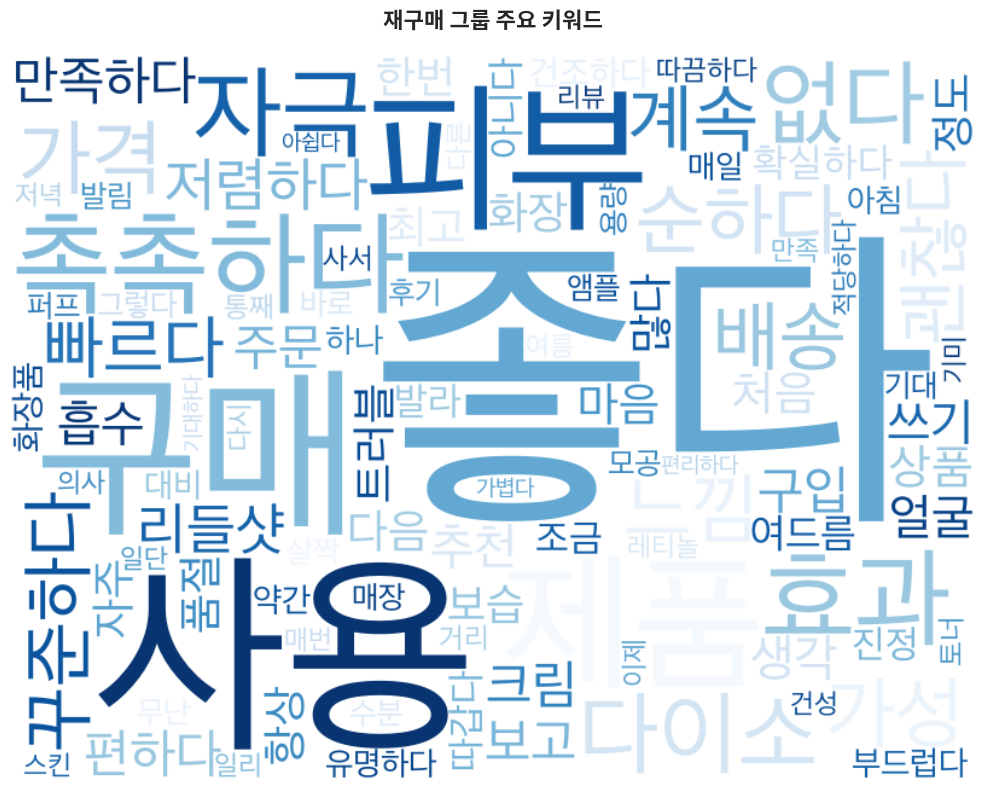

In [17]:
# 재구매 그룹 워드클라우드
create_wordcloud(
    tokens_repurchase_flat,
    title='재구매 그룹 주요 키워드',
    max_words=100,
    colormap='Blues'
)

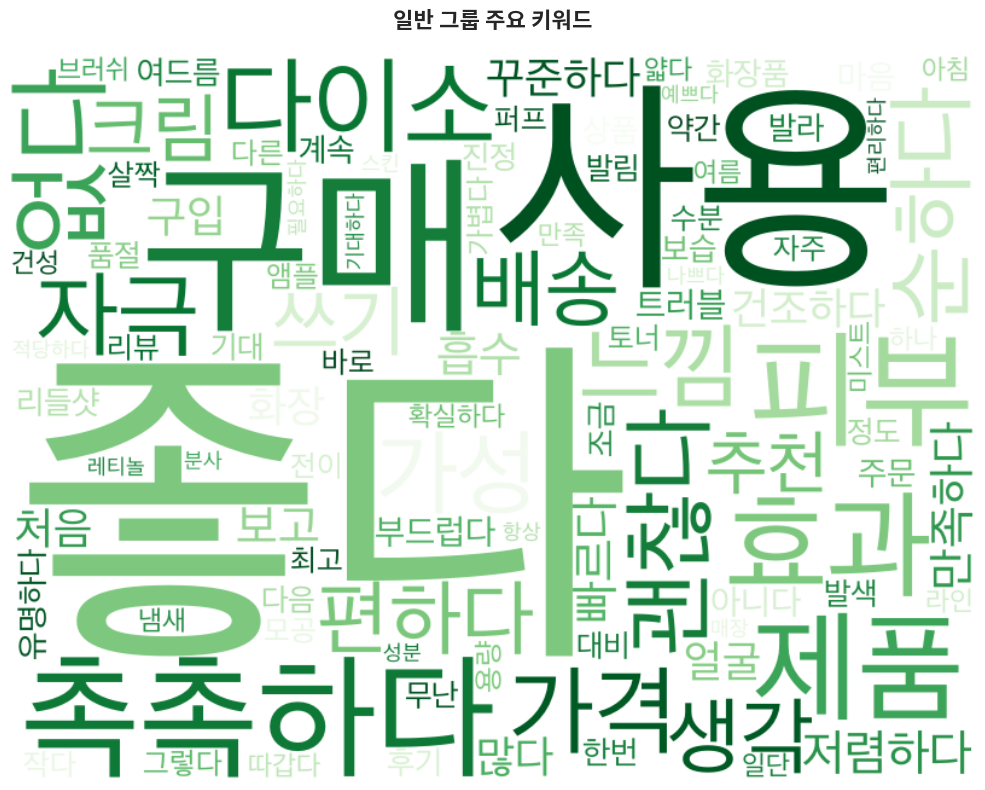

In [18]:
# 일반 그룹 워드클라우드
create_wordcloud(
    tokens_general_flat,
    title='일반 그룹 주요 키워드',
    max_words=100,
    colormap='Greens'
)

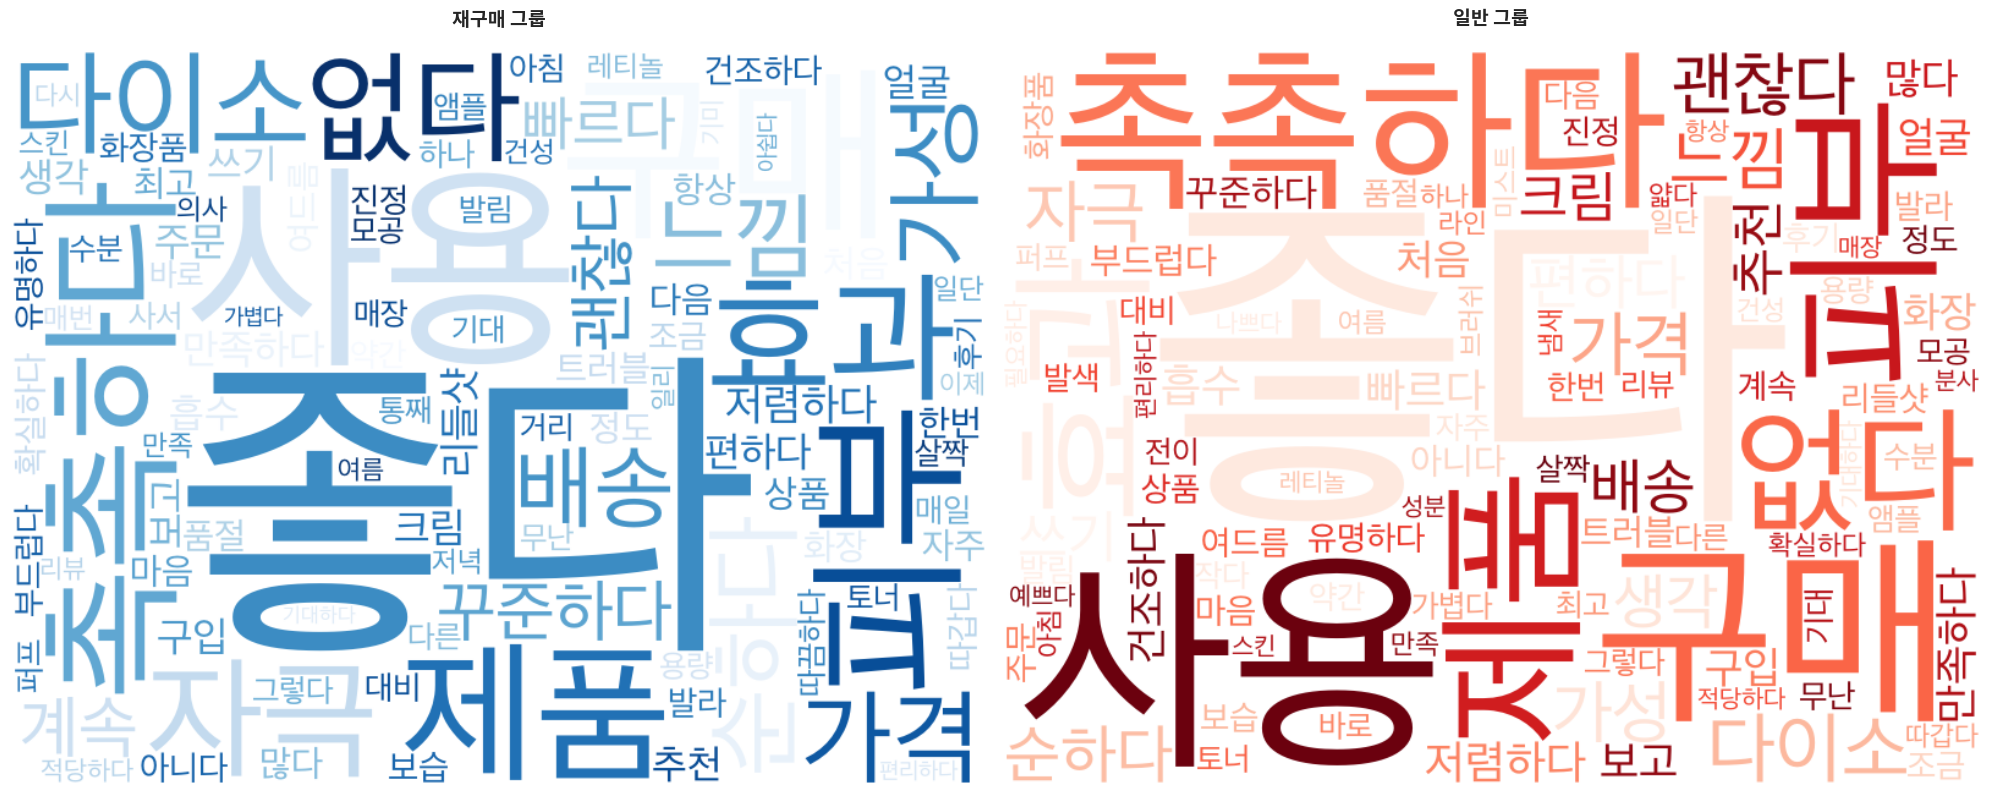

In [19]:
# 두 그룹 워드클라우드 비교
create_comparison_wordclouds(
    tokens_repurchase_flat,
    tokens_general_flat,
    title1='재구매 그룹',
    title2='일반 그룹',
    figsize=(20, 8)
)

## 8. 키워드 빈도 비교 그래프

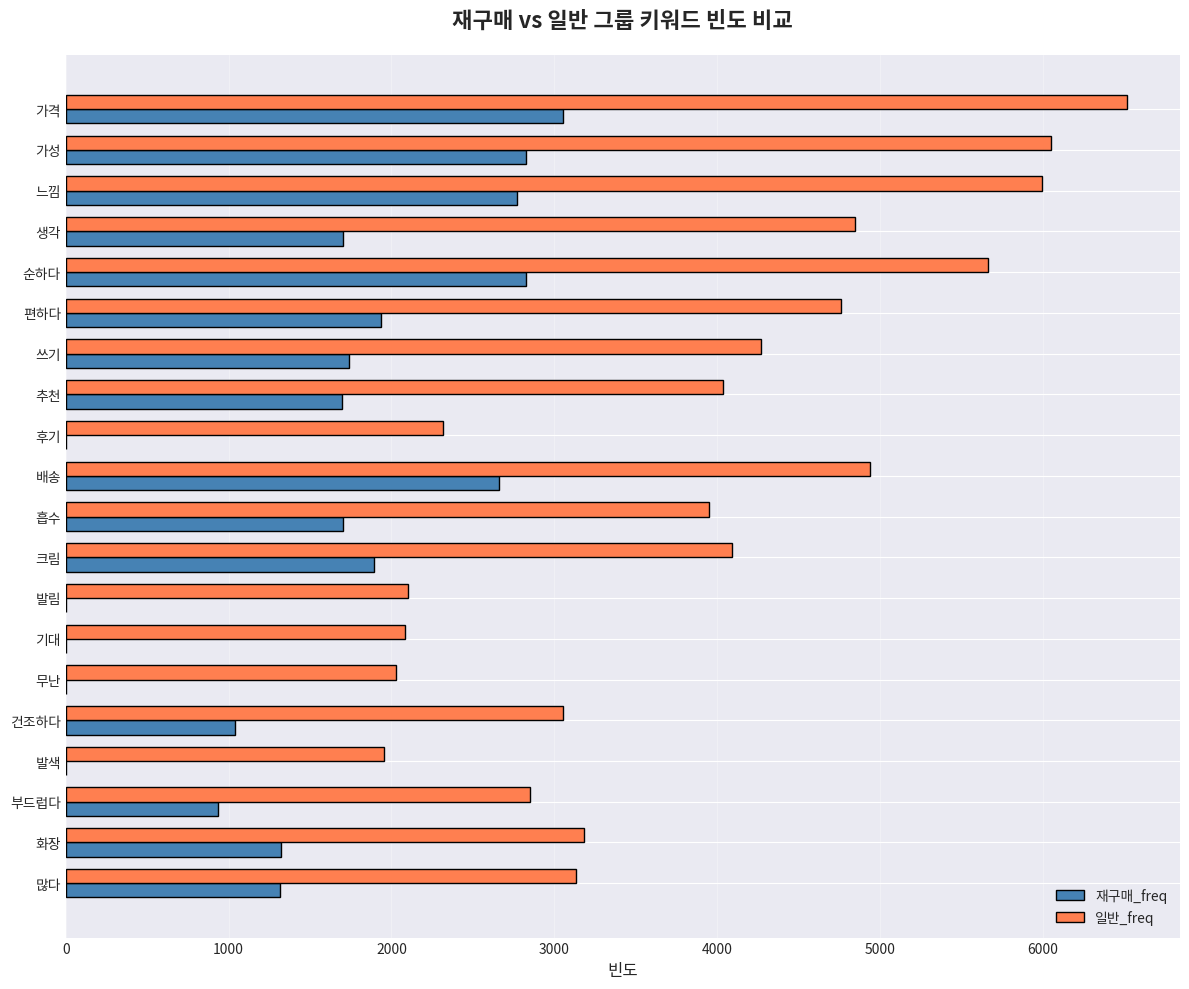

In [20]:
# 그룹 간 키워드 빈도 비교 막대 그래프
plot_keyword_comparison(
    df_comparison,
    group1_col='재구매_freq',
    group2_col='일반_freq',
    keyword_col='keyword',
    title='재구매 vs 일반 그룹 키워드 빈도 비교',
    top_n=20
)

## 9. 카테고리별 키워드 분석

**핵심 질문:**
- 재구매 그룹에서 '가성비' 키워드보다 '품질', '심미' 키워드가 더 많이 등장하는가?
- 재구매를 유도하는 핵심 속성은 무엇인가?

In [21]:
# 키워드 카테고리 확인
print("[키워드 카테고리]")
for category, keywords in KEYWORD_CATEGORIES.items():
    print(f"{category}: {keywords[:5]}")

[키워드 카테고리]
가성비: ['가성비', '싸[다고게요]', '저렴[하한]?', '가격', '저가']
품질[긍정]: ['품질\\s?[이가]?\\s?(?:좋|괜찮|최고|우수)', '효과\\s?[가]?\\s?(?:좋|괜찮|최고|있[다어요네])', '(?<!안\\s)(?<!안\\s)좋[다아고은아요네해]', '(?<!불)만족[스럽하해해요]', '훌륭[하한해해요]']
품질[부정]: ['트러블', '자극', '여드름', '뒤집', '알[레러]지']
심미[긍정]: ['디자인[이]?\\s?(?:좋|예쁘|멋지|깔끔|세련)', '패키지[가]?\\s?(?:좋|예쁘|깔끔|고급)', '용기[가]?\\s?(?:예쁘|좋)', '(?<!안\\s)예쁘[다고게네요해]', '(?<!안\\s)예뻐[요서며]']
심미[부정]: ['디자인[이]?\\s?별로|디자인\\s?안\\s?좋', '패키지[가]?\\s?별로|패키지\\s?안\\s?좋', '안\\s?예쁘', '안\\s?이쁘', '못\\s?생겼']
편의[긍정]: ['편[하한해해요](?!\\s?지\\s?않)', '간편[하한해해요](?!\\s?지\\s?않)', '사용감\\s?[이가]?\\s?(?:좋|괜찮)', '흡수\\s?[가]?\\s?(?:좋|빠르)|잘\\s?흡수|흡수력\\s?(?:좋|괜찮)', '발림성?\\s?[이가]?\\s?(?:좋|부드럽)|잘\\s?발[라려]']
물류[긍정]: ['배송\\s?빠르[다고게요]', '빠른\\s?배송', '칼배송', '재고\\s?있[다어었]', '품절\\s?안']
편의[부정]: ['(?<!안\\s)불편[하해함](?!\\s?지\\s?(?:는|도)?\\s?않)', '사용(?:하기)?\\s?(?:어렵[다고게]|어려[워요운])(?!\\s?지\\s?않)', '쓰기\\s?불편', '발림성?\\s?[이]?\\s?(?:안\\s?좋|별로)|잘\\s?안\\s?발[라려]', '흡수\\s?[가]?\\s?(?:안\\s?[되돼]|별로)']
물류[부정]: ['배송\\s?(?:느리[다고게]|느려[요서]|늦[다고게어]|안\\s?와|오래\\s?걸리|최

In [22]:
# 감성분석 카테고리 제외 (일반분석용)
sentiment_categories = ['품질[긍정]', '품질[부정]', '심미[긍정]', '심미[부정]', 
                        '편의[긍정]', '편의[부정]', '물류[긍정]', '물류[부정]']

general_analysis_categories = {k: v for k, v in KEYWORD_CATEGORIES.items() 
                               if k not in sentiment_categories}

# 재구매 그룹 카테고리별 빈도 (감성분석 제외)
df_repurchase_cat = calculate_category_frequency_for_reviews(
    tokens_repurchase,
    general_analysis_categories
)

print("[재구매 그룹 카테고리별 키워드 빈도 - 일반분석]")
print(df_repurchase_cat)

[재구매 그룹 카테고리별 키워드 빈도 - 일반분석]
  category  frequency
0      가성비       3159
1      희소성       1312
2     피부타입       1039
3   로드샵브랜드        213
4    브랜드개념        185
5    고가브랜드          6
6       듀프          1


In [23]:
# 일반 그룹 카테고리별 빈도 (감성분석 제외)
df_general_cat = calculate_category_frequency_for_reviews(
    tokens_general,
    general_analysis_categories
)

print("[일반 그룹 카테고리별 키워드 빈도 - 일반분석]")
print(df_general_cat)

[일반 그룹 카테고리별 키워드 빈도 - 일반분석]
  category  frequency
0      가성비       6783
1     피부타입       2399
2      희소성       1946
3   로드샵브랜드        554
4    브랜드개념        510
5    고가브랜드         22
6       듀프          3


In [24]:
# 카테고리별 비율 계산
ratios_repurchase = calculate_category_ratio(
    tokens_repurchase,
    category_pairs=[('품질', '가성비'), ('심미', '가성비'), ('편의', '가성비')],
    keyword_dict=KEYWORD_CATEGORIES
)

ratios_general = calculate_category_ratio(
    tokens_general,
    category_pairs=[('품질', '가성비'), ('심미', '가성비'), ('편의', '가성비')],
    keyword_dict=KEYWORD_CATEGORIES
)

print("[재구매 그룹 카테고리 비율]")
for key, value in ratios_repurchase.items():
    print(f"{key}: {value:.2f}")

print("\n[일반 그룹 카테고리 비율]")
for key, value in ratios_general.items():
    print(f"{key}: {value:.2f}")

[재구매 그룹 카테고리 비율]
품질/가성비: 2.82
심미/가성비: 0.00
편의/가성비: 0.00

[일반 그룹 카테고리 비율]
품질/가성비: 2.05
심미/가성비: 0.00
편의/가성비: 0.00


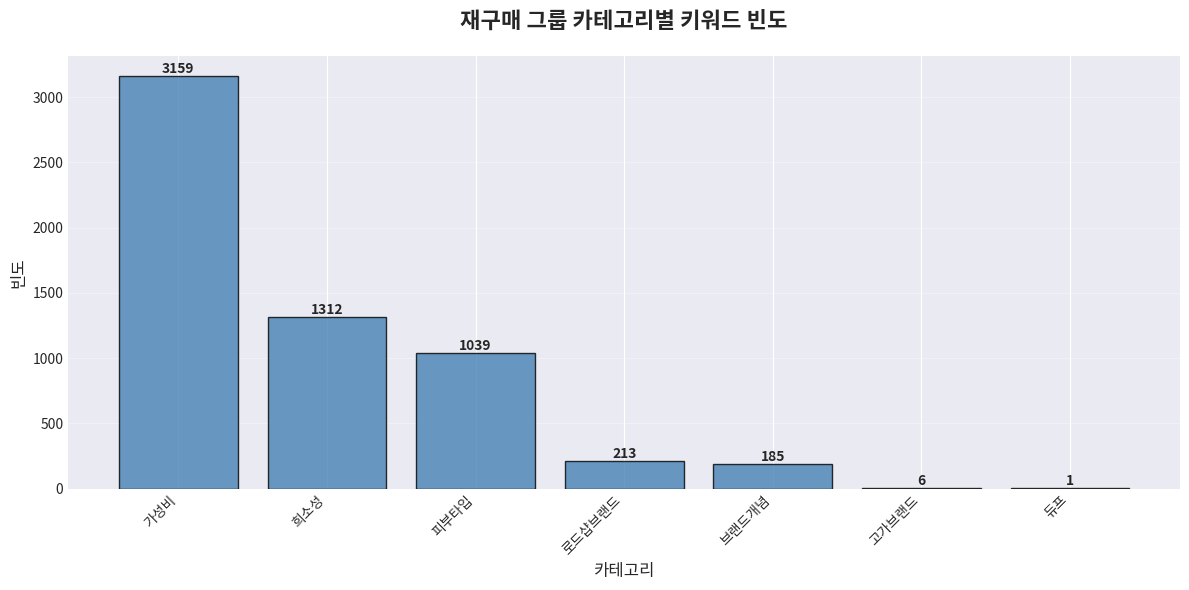

In [25]:
# 재구매 그룹 카테고리별 빈도
plot_category_comparison(
    df_repurchase_cat,
    title='재구매 그룹 카테고리별 키워드 빈도',
    color='steelblue'
)

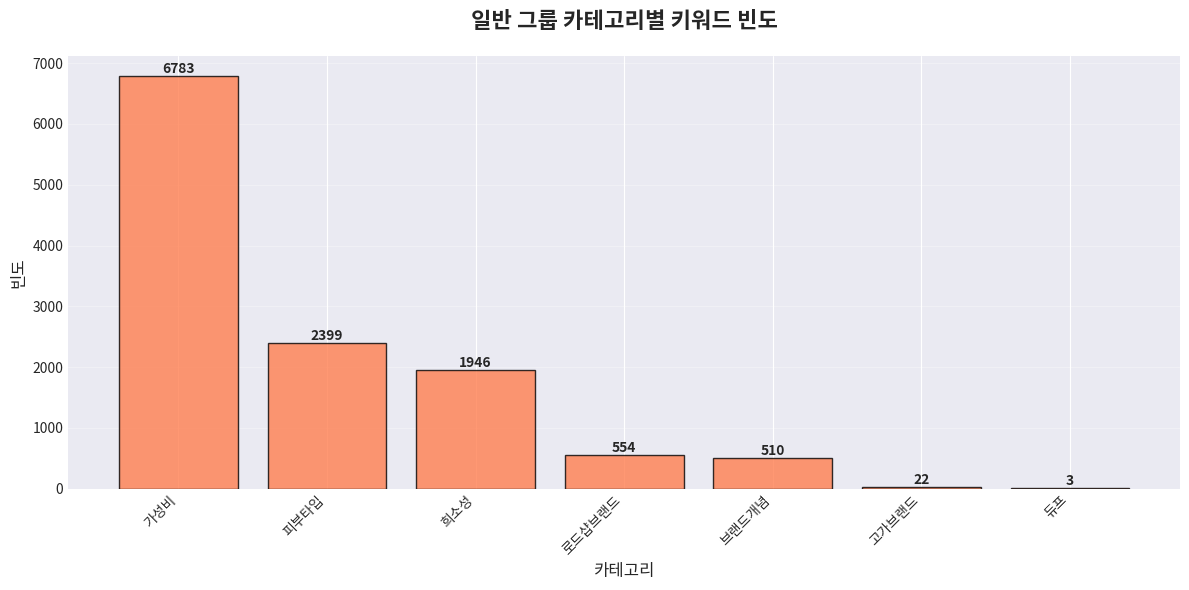

In [26]:
# 일반 그룹 카테고리별 빈도
plot_category_comparison(
    df_general_cat,
    title='일반 그룹 카테고리별 키워드 빈도',
    color='coral'
)

In [27]:
# 그룹별 카테고리 비교 (그룹화 막대 그래프)
# 데이터프레임 병합
df_cat_comparison = pd.merge(
    df_repurchase_cat,
    df_general_cat,
    on='category',
    suffixes=('_재구매', '_일반')
)

# 비율 계산 (정규화)
df_cat_comparison['재구매_비율'] = (df_cat_comparison['frequency_재구매'] / 
                                  df_cat_comparison['frequency_재구매'].sum() * 100)
df_cat_comparison['일반_비율'] = (df_cat_comparison['frequency_일반'] / 
                                df_cat_comparison['frequency_일반'].sum() * 100)

print("[카테고리별 비율 비교]")
print(df_cat_comparison[['category', '재구매_비율', '일반_비율']])

[카테고리별 비율 비교]
  category     재구매_비율      일반_비율
0      가성비  53.406593  55.520995
1      희소성  22.180896  15.928624
2     피부타입  17.565511  19.636572
3   로드샵브랜드   3.601014   4.534665
4    브랜드개념   3.127642   4.174511
5    고가브랜드   0.101437   0.180077
6       듀프   0.016906   0.024556


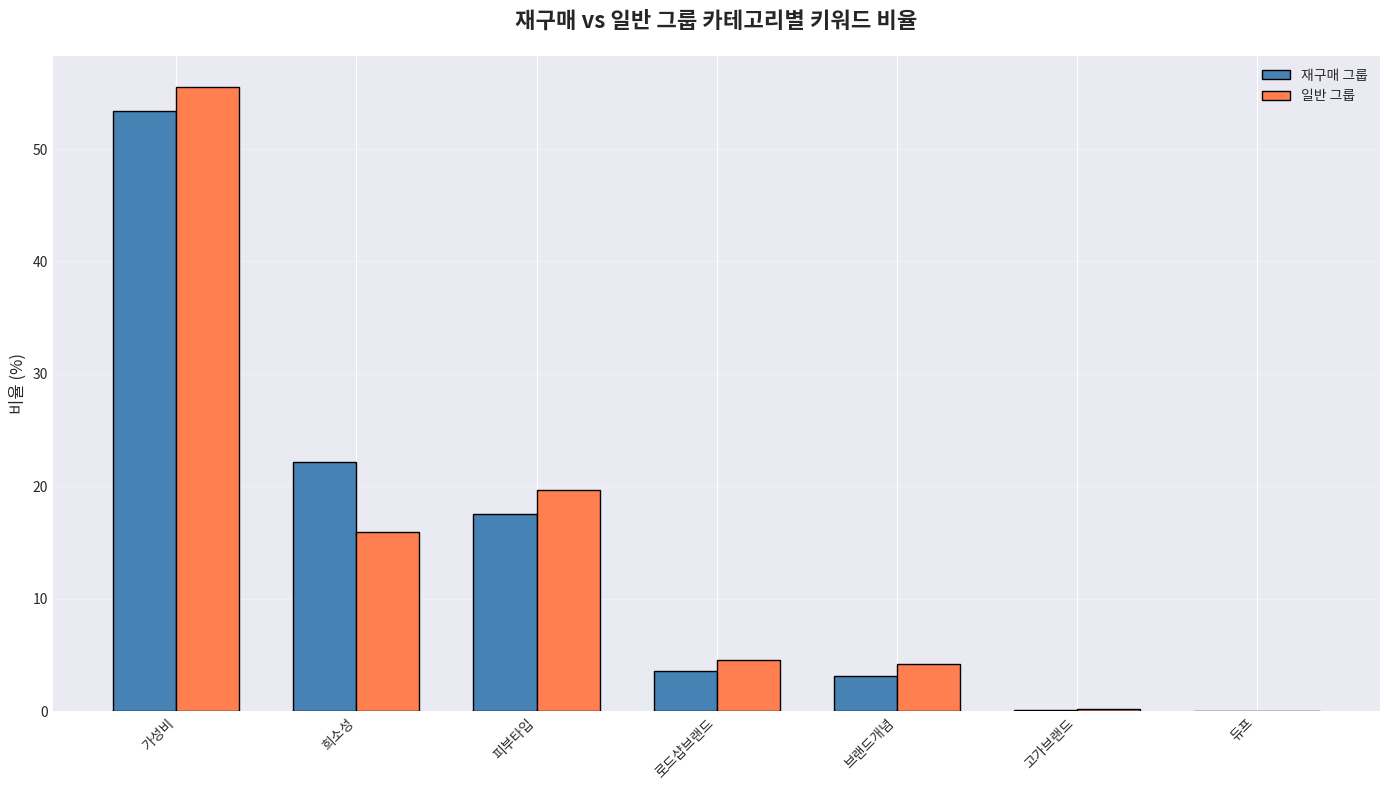

In [28]:
# 그룹별 카테고리 비율 비교
fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(df_cat_comparison))
width = 0.35

ax.bar([i - width/2 for i in x], df_cat_comparison['재구매_비율'], width,
       label='재구매 그룹', color='steelblue', edgecolor='black')
ax.bar([i + width/2 for i in x], df_cat_comparison['일반_비율'], width,
       label='일반 그룹', color='coral', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(df_cat_comparison['category'], rotation=45, ha='right')
ax.set_ylabel('비율 (%)', fontsize=12)
ax.set_title('재구매 vs 일반 그룹 카테고리별 키워드 비율', fontsize=16, fontweight='bold', pad=20)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
import re

print("="*80)
print("[카테고리별 패턴 매칭 확인]")
print("="*80)

# 재구매 그룹 샘플 추출
sample_reviews = df_reviews[df_reviews['is_재구매']].head(20)

# 각 카테고리별 패턴 매칭 확인
categories_to_check = ['가성비', '품질[긍정]', '심미[긍정]', '편의[긍정]', '물류[부정]', '품질[부정]']

for category in categories_to_check:
    print(f"\n{'='*80}")
    print(f"[{category} 패턴 매칭 확인]")
    print(f"{'='*80}")
    
    patterns = KEYWORD_CATEGORIES[category]
    print(f"패턴 목록: {patterns}\n")
    
    # 해당 카테고리가 매칭되는 리뷰 찾기
    matched_count = 0
    for idx, row in sample_reviews.iterrows():
        text = str(row['text'])
        matched_patterns = []
        
        for pattern in patterns:
            if re.search(pattern, text):
                matched_patterns.append(pattern)
        
        if matched_patterns:
            matched_count += 1
            print(f"\n평점 {row['rating']}점: {text[:150]}")
            print(f"→ 매칭된 패턴: {', '.join(matched_patterns)}")
            
            if matched_count >= 5:  # 카테고리당 최대 5개 샘플
                break
    
    if matched_count == 0:
        print("(샘플 20개 중 매칭 없음)")

print(f"\n{'='*80}")
print("[패턴 매칭 확인 완료]")
print(f"{'='*80}")

[카테고리별 패턴 매칭 확인]

[가성비 패턴 매칭 확인]
패턴 목록: ['가성비', '싸[다고게요]', '저렴[하한]?', '가격', '저가', '착[하한]', '가격대', '합리', '경제', '부담[없안적]', '비싸[다고]?', '천원', '가격대비', '\\d+원', '행사', '할인']


평점 5점: 재구매 양도 많은데 깔끔한 보관통까지... 항상 가성비와 가심비에 놀라고 있습니다.
→ 매칭된 패턴: 가성비

평점 5점: 재구매 저렴한가격에 구매했어요
→ 매칭된 패턴: 저렴[하한]?, 가격

평점 4점: 재구매 갯수많고 가격은 저렴해서 가성비는 최고에요. 대신 잘 부러지는 면봉도 꽤 들어있어요ㅠ
→ 매칭된 패턴: 가성비, 저렴[하한]?, 가격

평점 5점: 재구매 가격저렴하고양도많고사용하기편하네여..
→ 매칭된 패턴: 저렴[하한]?, 가격

평점 5점: 재구매 가성비굿 실밥도 없음
→ 매칭된 패턴: 가성비

[품질[긍정] 패턴 매칭 확인]
패턴 목록: ['품질\\s?[이가]?\\s?(?:좋|괜찮|최고|우수)', '효과\\s?[가]?\\s?(?:좋|괜찮|최고|있[다어요네])', '(?<!안\\s)(?<!안\\s)좋[다아고은아요네해]', '(?<!불)만족[스럽하해해요]', '훌륭[하한해해요]', '퀄리티\\s?[가]?\\s?(?:좋|최고|우수)', '우수[하한해해요]', '괜찮[다아고게네요아]', '최고', '완벽[하한해해요]', '추천[해하해요]', '대박', '신기[하한해해요]', '놀랍[다고게게요]', '기대\\s?이상|기대보다\\s?좋', '성능\\s?[이가]?\\s?(?:좋|괜찮|최고)', '쓸만[하한해해요]', '생각보다\\s?좋', '가심비', '다이소\\s?최고|다이소만', '인생템', '정착[했해해요]', '재구매[할해해요]', '광채\\s?[가]?\\s?좋|광채\\s?나[요네]', '탄력\\s?[이]?\\s?좋|탄력\\s?있[다어요네]', '보습[력]?\\s?(?:좋|최고)', '진정[효과]?\\s?좋|진정\\s?[이]?\\s?[되돼

## 10. 감성 카테고리 분석

**분석 목표:**
- 제품 속성별 긍정/부정 감성 분리 분석
- 심미(디자인), 편의(사용성), 물류에 대한 감성 패턴 파악

### 10.1 심미 분석

In [30]:
# 심미 긍정 키워드 분석
import re
from keyword_analysis import extract_reviews_with_keywords

aesthetic_positive_keywords = KEYWORD_CATEGORIES['심미[긍정]']

df_aesthetic_pos = extract_reviews_with_keywords(
    df_reviews,
    keywords=aesthetic_positive_keywords,
    text_column='text'
)

print(f"[심미 긍정 언급 리뷰]")
print(f"총 {len(df_aesthetic_pos):,}개 ({len(df_aesthetic_pos)/len(df_reviews)*100:.2f}%)")
print(f"평균 평점: {df_aesthetic_pos['rating'].mean():.2f}")

# 패턴 매칭 확인
print("\n[심미 긍정 패턴 매칭 확인]")
print("=" * 80)

for idx, row in df_aesthetic_pos.head(10).iterrows():
    text = str(row['text'])
    print(f"\n평점 {row['rating']}점: {text[:100]}")
    
    matched_patterns = []
    for pattern in aesthetic_positive_keywords:
        if re.search(pattern, text):
            matched_patterns.append(pattern)
    
    if matched_patterns:
        print(f"→ 매칭된 패턴: {', '.join(matched_patterns[:3])}")  # 최대 3개만 표시
    print("-" * 80)

[심미 긍정 언급 리뷰]
총 2,818개 (1.41%)
평균 평점: 4.83

[심미 긍정 패턴 매칭 확인]

평점 5점: 재구매 양도 많은데 깔끔한 보관통까지... 항상 가성비와 가심비에 놀라고 있습니다.
→ 매칭된 패턴: 깔끔[하한해해요]
--------------------------------------------------------------------------------

평점 5점: 처음 뿌렸을때보다 잔향이 훨신좋아요 ㅎ 뿌려놓고 은은하게 올라오는 향이 고급스럽네요 ㅎ
→ 매칭된 패턴: 고급[스럽져스러워]|고급미|고급\s?느낌
--------------------------------------------------------------------------------

평점 5점: 재구매 촉촉하고 맘에 들어요^.^ 작아서 귀엽고 여행갈때 들고다니기 좋을것 같아요
→ 매칭된 패턴: 귀엽[다고게네요해]|귀여워[요서]
--------------------------------------------------------------------------------

평점 5점: 아직 써보지는 않았지만 쿨톤한테 예쁘다는 평이 많아서 구매해봤어요
→ 매칭된 패턴: (?<!안\s)예쁘[다고게네요해]
--------------------------------------------------------------------------------

평점 5점: 이거.. 롬×의 베어 포도 색이랑 비슷해요 ㅋㅋㅋㅋ 향도 달달하고 색 이쁘고 지속력 좋습니다. 탕후루 립까진 아니더라도 광택 충분히 이쁘게 나요 강추!!!
→ 매칭된 패턴: (?<!안\s)이쁘[다고게네요해]
--------------------------------------------------------------------------------

평점 5점: 재구매 이 시리즈 세 개 다 샀는데 커버력도 완전 좋고깔끔하게 발려용!!
→ 매칭된 패턴: 깔끔[하한해해요]
-------------------

In [31]:
# 심미 부정 키워드 분석
import re
from keyword_analysis import extract_reviews_with_keywords

aesthetic_negative_keywords = KEYWORD_CATEGORIES['심미[부정]']

df_aesthetic_neg = extract_reviews_with_keywords(
    df_reviews,
    keywords=aesthetic_negative_keywords,
    text_column='text'
)

print(f"[심미 부정 언급 리뷰]")
print(f"총 {len(df_aesthetic_neg):,}개 ({len(df_aesthetic_neg)/len(df_reviews)*100:.2f}%)")
print(f"평균 평점: {df_aesthetic_neg['rating'].mean():.2f}")

# 패턴 매칭 확인
print("\n[심미 부정 패턴 매칭 확인]")
print("=" * 80)

for idx, row in df_aesthetic_neg.head(10).iterrows():
    text = str(row['text'])
    print(f"\n평점 {row['rating']}점: {text[:100]}")
    
    matched_patterns = []
    for pattern in aesthetic_negative_keywords:
        if re.search(pattern, text):
            matched_patterns.append(pattern)
    
    if matched_patterns:
        print(f"→ 매칭된 패턴: {', '.join(matched_patterns[:3])}")  # 최대 3개만 표시
    print("-" * 80)

[심미 부정 언급 리뷰]
총 35개 (0.02%)
평균 평점: 3.89

[심미 부정 패턴 매칭 확인]

평점 5점: 완전 좋아요 감사합니다 근데 택배상자는 좀 많이 허술하네요...
→ 매칭된 패턴: 택배\s?상자.*허술|포장.*허술
--------------------------------------------------------------------------------

평점 5점: 완전 좋아요 감사합니다 근데 택배상자는 좀 많이 허술하네요...
→ 매칭된 패턴: 택배\s?상자.*허술|포장.*허술
--------------------------------------------------------------------------------

평점 4점: 색깔이 별로네요 ㅜㅠ
→ 매칭된 패턴: 색깔[이]\s?별로
--------------------------------------------------------------------------------

평점 5점: 알로에함량 92퍼 제품 썼을 땐 얼굴 따끔하고 화끈해서 참 힘들게 비웠는데 이건 전혀 자극없음. 몹시 호감…. 이렇게 치약쩌럼 짜는 디자인 별로 안 좋아했는데, 써보니까 괜찮네요.
→ 매칭된 패턴: 디자인[이]?\s?별로|디자인\s?안\s?좋
--------------------------------------------------------------------------------

평점 5점: 바닥 부분이 불투명 플라스틱 데 좀 저렴해보여요. 리필 2개가 들어있어 좋아요.
→ 매칭된 패턴: 저렴해\s?보[여이]|저렴하게\s?보[여이]
--------------------------------------------------------------------------------

평점 3점: 생각보다 색이 별로라 안쓰게 되네요
→ 매칭된 패턴: 색상[이]\s?별로|색[이]\s?별로
-----------------------------------------------------------

### 10.2 편의 분석

In [32]:
# 편의 긍정 키워드 분석
convenience_positive_keywords = KEYWORD_CATEGORIES['편의[긍정]']

df_convenience_pos = extract_reviews_with_keywords(
    df_reviews,
    keywords=convenience_positive_keywords,
    text_column='text'
)

print(f"[편의 긍정 언급 리뷰]")
print(f"총 {len(df_convenience_pos):,}개 ({len(df_convenience_pos)/len(df_reviews)*100:.2f}%)")
print(f"평균 평점: {df_convenience_pos['rating'].mean():.2f}")

# 패턴 매칭 확인
print("\n[편의 긍정 패턴 매칭 확인]")
print("=" * 80)

for idx, row in df_convenience_pos.head(10).iterrows():
    text = str(row['text'])
    print(f"\n평점 {row['rating']}점: {text[:100]}")
    
    matched_patterns = []
    for pattern in convenience_positive_keywords:
        if re.search(pattern, text):
            matched_patterns.append(pattern)
    
    if matched_patterns:
        print(f"→ 매칭된 패턴: {', '.join(matched_patterns[:3])}")
    print("-" * 80)

[편의 긍정 언급 리뷰]
총 39,708개 (19.81%)
평균 평점: 4.83

[편의 긍정 패턴 매칭 확인]

평점 5점: 순해서 잘쓰고 있어용!
→ 매칭된 패턴: 순[하한해해요]
--------------------------------------------------------------------------------

평점 5점: 재구매 가격저렴하고양도많고사용하기편하네여..
→ 매칭된 패턴: 편[하한해해요](?!\s?지\s?않)
--------------------------------------------------------------------------------

평점 5점: 화장할때 쓰기 편해요 많이 들어 있어서 오래 두고 쓸수 있을것 같아요
→ 매칭된 패턴: 편[하한해해요](?!\s?지\s?않)
--------------------------------------------------------------------------------

평점 5점: 저렴하고, 플라스틱이 아니라 나무면봉인 점도 좋습니다. 편하게 쓰기 좋아요.
→ 매칭된 패턴: 편[하한해해요](?!\s?지\s?않)
--------------------------------------------------------------------------------

평점 5점: 작은게 많아서 한번쓰고 버릴수있어 편하고 위생적임
생각보다 질은 퍽퍽하지않고 말랑말랑 좋았어요
귀찮아서 빨아쓰기 싫어하는 사람으로써 대만족
→ 매칭된 패턴: 편[하한해해요](?!\s?지\s?않)
--------------------------------------------------------------------------------

평점 5점: 써보니 너무 만족스러워요. 촉촉합니다.
스킨대신 발라도 편하고, 바디로션대신 뿌려도 좋네요.
→ 매칭된 패턴: 편[하한해해요](?!\s?지\s?않)
------------------------------------------------------------

In [33]:
# 편의 부정 키워드 분석
convenience_negative_keywords = KEYWORD_CATEGORIES['편의[부정]']

df_convenience_neg = extract_reviews_with_keywords(
    df_reviews,
    keywords=convenience_negative_keywords,
    text_column='text'
)

print(f"[편의 부정 언급 리뷰]")
print(f"총 {len(df_convenience_neg):,}개 ({len(df_convenience_neg)/len(df_reviews)*100:.2f}%)")
print(f"평균 평점: {df_convenience_neg['rating'].mean():.2f}")

# 패턴 매칭 확인
print("\n[편의 부정 패턴 매칭 확인]")
print("=" * 80)

for idx, row in df_convenience_neg.head(10).iterrows():
    text = str(row['text'])
    print(f"\n평점 {row['rating']}점: {text[:100]}")
    
    matched_patterns = []
    for pattern in convenience_negative_keywords:
        if re.search(pattern, text):
            matched_patterns.append(pattern)
    
    if matched_patterns:
        print(f"→ 매칭된 패턴: {', '.join(matched_patterns[:3])}")
    print("-" * 80)

[편의 부정 언급 리뷰]
총 1,506개 (0.75%)
평균 평점: 4.45

[편의 부정 패턴 매칭 확인]

평점 3점: 흡수가 안되고 꾸덕하게 발려서 버렸어요ㅠ 가히 쓰기전에 사본건데 저한텐 안 맞는 듯
→ 매칭된 패턴: 흡수\s?[가]?\s?(?:안\s?[되돼]|별로)
--------------------------------------------------------------------------------

평점 5점: 재구매 열고 닫는게 조금 불편하지만 한장씩 뽑아 쓸 수 있어서 좋아요
재질도 좋아요
→ 매칭된 패턴: (?<!안\s)불편[하해함](?!\s?지\s?(?:는|도)?\s?않)
--------------------------------------------------------------------------------

평점 3점: 기름 흡수력은 좋네요 근데 저만 그런거인지는 모르겠지만..ㅋㅋ 첨에 꺼낼때 좀 불편하더라구여 ㅜㅠ 그래서 재구매 의향은 아직 없네요.. 그래도 흡수는 잘 됩니다
→ 매칭된 패턴: (?<!안\s)불편[하해함](?!\s?지\s?(?:는|도)?\s?않)
--------------------------------------------------------------------------------

평점 5점: 발색은 보통이고 손에는 잘 칠해졌지만 애굣살에 바르려니까 뭉쳐서 되더군요... 하지만 이가격에 나쁘지는 않아서 사용하긴 하지만 재구매의사는 없습니다
→ 매칭된 패턴: (?<!안\s)뭉[치쳐침]
--------------------------------------------------------------------------------

평점 5점: 너무좋아요 기존쓰던쿠션보다 훨씬좋네요
잘안뜨고 잘안뭉쳐요 커버도괜찮네요
→ 매칭된 패턴: (?<!안\s)뭉[치쳐침]
--------------------------------------------------------------------------------



### 10.3 물류 긍정 분석

In [34]:
# 물류 긍정 키워드 분석
logistics_positive_keywords = KEYWORD_CATEGORIES['물류[긍정]']

df_logistics_pos = extract_reviews_with_keywords(
    df_reviews,
    keywords=logistics_positive_keywords,
    text_column='text'
)

print(f"[물류 긍정 언급 리뷰]")
print(f"총 {len(df_logistics_pos):,}개 ({len(df_logistics_pos)/len(df_reviews)*100:.2f}%)")
print(f"평균 평점: {df_logistics_pos['rating'].mean():.2f}")

# 패턴 매칭 확인
print("\n[물류 긍정 패턴 매칭 확인]")
print("=" * 80)

for idx, row in df_logistics_pos.head(10).iterrows():
    text = str(row['text'])
    print(f"\n평점 {row['rating']}점: {text[:100]}")
    
    matched_patterns = []
    for pattern in logistics_positive_keywords:
        if re.search(pattern, text):
            matched_patterns.append(pattern)
    
    if matched_patterns:
        print(f"→ 매칭된 패턴: {', '.join(matched_patterns[:3])}")  # 최대 3개만 표시
    print("-" * 80)

[물류 긍정 언급 리뷰]
총 2,913개 (1.45%)
평균 평점: 4.86

[물류 긍정 패턴 매칭 확인]

평점 5점: 배송빠르고 잘 받았습니다.
→ 매칭된 패턴: 배송\s?빠르[다고게요]
--------------------------------------------------------------------------------

평점 5점: 배송 빠르고 좋아요
→ 매칭된 패턴: 배송\s?빠르[다고게요]
--------------------------------------------------------------------------------

평점 5점: 우선 빠른 배송, 확실한 포장이 마음에 듭니다
제품은 제피부엔 약간 따가운 느낌이 있네요
효과를 기대해보며 잘 사용하겠습니다 ^^
→ 매칭된 패턴: 빠른\s?배송
--------------------------------------------------------------------------------

평점 5점: 재구매 빠른배송 감사합니다 100짜리는 얼굴전체에바르고 300짜리는 좀더 국소부위에 사용해봤는데 화장도 잘먹고 각질도 덜일어나는 느낌입니다 잘쓸게요~
→ 매칭된 패턴: 빠른\s?배송
--------------------------------------------------------------------------------

평점 5점: 빠른 배송 좋아요 ㅎㅎㅎ
너무 묵직하긴해요
→ 매칭된 패턴: 빠른\s?배송
--------------------------------------------------------------------------------

평점 5점: 재입고 빠르게 해주시면 감사하겠습니다
→ 매칭된 패턴: 입고\s?빠르[다더게요]
--------------------------------------------------------------------------------

평점 5점: 빠른 배송 정말 잘 받았습니다
→ 매칭된 패턴: 빠른\s?배송
--------

In [35]:
# 물류 부정 키워드 분석
logistics_negative_keywords = KEYWORD_CATEGORIES['물류[부정]']

df_logistics_neg = extract_reviews_with_keywords(
    df_reviews,
    keywords=logistics_negative_keywords,
    text_column='text'
)

print(f"[물류 부정 언급 리뷰]")
print(f"총 {len(df_logistics_neg):,}개 ({len(df_logistics_neg)/len(df_reviews)*100:.2f}%)")
print(f"평균 평점: {df_logistics_neg['rating'].mean():.2f}")

# 패턴 매칭 확인
print("\n[물류 부정 패턴 매칭 확인]")
print("=" * 80)

for idx, row in df_logistics_neg.head(10).iterrows():
    text = str(row['text'])
    print(f"\n평점 {row['rating']}점: {text[:100]}")
    
    matched_patterns = []
    for pattern in logistics_negative_keywords:
        if re.search(pattern, text):
            matched_patterns.append(pattern)
    
    if matched_patterns:
        print(f"→ 매칭된 패턴: {', '.join(matched_patterns[:3])}")  # 최대 3개만 표시
    print("-" * 80)

[물류 부정 언급 리뷰]
총 3,423개 (1.71%)
평균 평점: 4.86

[물류 부정 패턴 매칭 확인]

평점 4점: 나무면봉 말고
하얀색으로 구매 하고팠는데
상품이 없어서 이걸로
→ 매칭된 패턴: 상품\s?[이]?\s?없
--------------------------------------------------------------------------------

평점 5점: 재구매 품절대란인데 좋다고해서 구매해봅니다
→ 매칭된 패턴: 품절
--------------------------------------------------------------------------------

평점 5점: 재구매 데일리용이나 처음 써보는 분은 무조건 리들샷 100으로 시작하세요. 구하기 어려운데 택배가 되니 너무 편리하네요.
→ 매칭된 패턴: 구하기\s?(?:어렵[다고게]|어려[워요운]|힘들[다고게어요운])
--------------------------------------------------------------------------------

평점 5점: 재구매 드디어 구했네요. 다이소 갈때마다 품절이고 여기서도 품절이였는데 드디어 제 손에 들어왔네요.🤗
배송지연으로 조금 더 지다려야 했지만 많이 기대되고 설레네요.효과가 있었으면 
→ 매칭된 패턴: 품절
--------------------------------------------------------------------------------

평점 5점: 재구매 리들샷 좋다고 그러길래 주문해봤는데
오늘 첫날 바른거라 좋은건 며칠 써봐야 알겠어요
정말 따꼼따꼼 거리긴하네요
약간 빨개지구요
지금 4시간지나서 건조하길래
크림 덧발랐는데도
→ 매칭된 패턴: 품절
--------------------------------------------------------------------------------

평점 5점: 재구매 드디어 구했네요. 다이소 갈때마다 품절이고 여기서도 품절이였는데 드디어 제 손

### 10.4 긍정/부정 비교 분석

In [36]:
# 긍정/부정 감성 종합 비교
sentiment_comparison = pd.DataFrame({
    '카테고리': ['심미 [긍정]', '심미 [부정]', '편의 [긍정]', '편의 [부정]', '물류 [긍정]', '물류 [부정]'],
    '언급 리뷰 수': [
        len(df_aesthetic_pos),
        len(df_aesthetic_neg),
        len(df_convenience_pos),
        len(df_convenience_neg),
        len(df_logistics_pos),
        len(df_logistics_neg)
    ],
    '전체 대비 비율(%)': [
        len(df_aesthetic_pos)/len(df_reviews)*100,
        len(df_aesthetic_neg)/len(df_reviews)*100,
        len(df_convenience_pos)/len(df_reviews)*100,
        len(df_convenience_neg)/len(df_reviews)*100,
        len(df_logistics_pos)/len(df_reviews)*100,
        len(df_logistics_neg)/len(df_reviews)*100
    ],
    '평균 평점': [
        df_aesthetic_pos['rating'].mean() if len(df_aesthetic_pos) > 0 else 0,
        df_aesthetic_neg['rating'].mean() if len(df_aesthetic_neg) > 0 else 0,
        df_convenience_pos['rating'].mean() if len(df_convenience_pos) > 0 else 0,
        df_convenience_neg['rating'].mean() if len(df_convenience_neg) > 0 else 0,
        df_logistics_pos['rating'].mean() if len(df_logistics_pos) > 0 else 0,
        df_logistics_neg['rating'].mean() if len(df_logistics_neg) > 0 else 0
    ]
})

print("\n[긍정/부정 감성 종합]")
print(sentiment_comparison.to_string(index=False))


[긍정/부정 감성 종합]
   카테고리  언급 리뷰 수  전체 대비 비율(%)    평균 평점
심미 [긍정]     2818     1.406160 4.834280
심미 [부정]       35     0.017465 3.885714
편의 [긍정]    39708    19.813976 4.828045
편의 [부정]     1506     0.751482 4.445551
물류 [긍정]     2913     1.453564 4.864058
물류 [부정]     3423     1.708050 4.855682


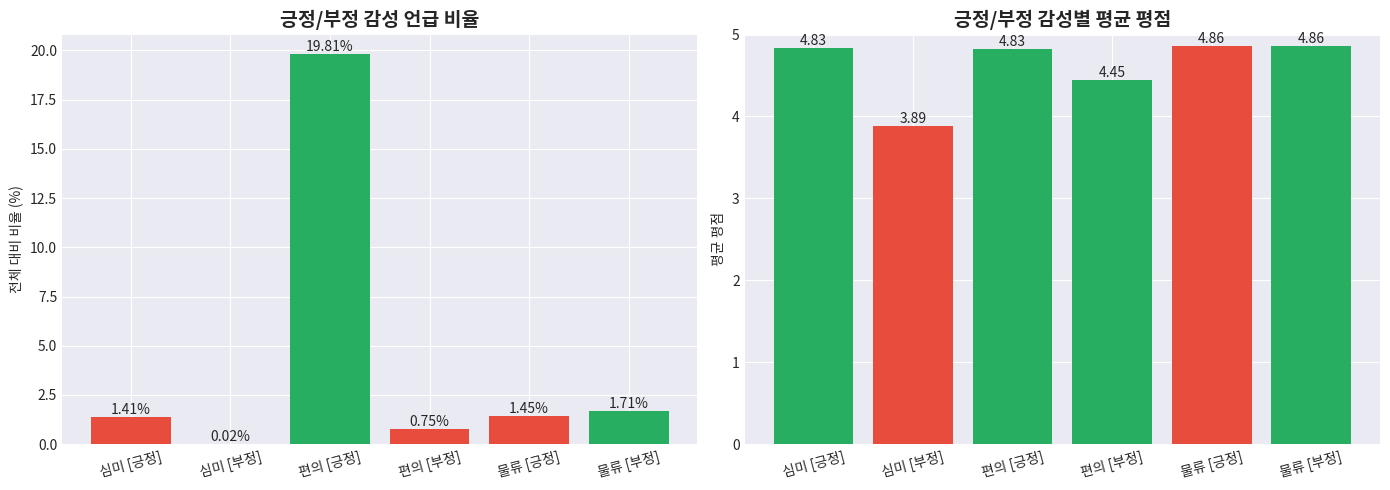

In [37]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 언급 비율
axes[0].bar(sentiment_comparison['카테고리'], sentiment_comparison['전체 대비 비율(%)'],
            color=['#e74c3c', '#e74c3c', '#27ae60'])
axes[0].set_title('긍정/부정 감성 언급 비율', fontsize=14, fontweight='bold')
axes[0].set_ylabel('전체 대비 비율 (%)')
axes[0].tick_params(axis='x', rotation=15)

for i, v in enumerate(sentiment_comparison['전체 대비 비율(%)']):
    axes[0].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# 평균 평점
axes[1].bar(sentiment_comparison['카테고리'], sentiment_comparison['평균 평점'],
            color=['#27ae60', '#e74c3c', '#27ae60'])
axes[1].set_title('긍정/부정 감성별 평균 평점', fontsize=14, fontweight='bold')
axes[1].set_ylabel('평균 평점')
axes[1].set_ylim([0, 5])
axes[1].tick_params(axis='x', rotation=15)

for i, v in enumerate(sentiment_comparison['평균 평점']):
    axes[1].text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



## 10. 물류 vs 제품 품질 불만 분리 분석

**분석 목표:**
- "제품은 좋은데 구하기 힘들다(희소성)" 패턴 확인
- 물류 불만과 제품 품질 불만을 철저히 분리

In [38]:
# 물류 키워드와 품질불만 키워드 빈도 비교
logistics_keywords = KEYWORD_CATEGORIES['물류[부정]']
quality_issue_keywords = KEYWORD_CATEGORIES['품질[부정]']

print(f"[물류 키워드]: {logistics_keywords}")
print(f"[품질불만 키워드]: {quality_issue_keywords}")

[물류 키워드]: ['배송\\s?(?:느리[다고게]|느려[요서]|늦[다고게어]|안\\s?와|오래\\s?걸리|최악|별로)', '재고\\s?[가는]?\\s?없', '품절', '매진', '입고\\s?(?:늦[다고게어]|안\\s?[되돼]|오래\\s?걸리|느리[다고]|느려[요서])', '택배\\s?(?:느리[다고게]|느려[요서]|늦[다고게어]|안\\s?와|오래\\s?걸리|최악|별로)', '예약\\s?(?:안\\s?[되돼]|불가|막혔|어렵[다고게]|어려[워요운])', '구하기\\s?(?:어렵[다고게]|어려[워요운]|힘들[다고게어요운])', '찾기\\s?(?:어렵[다고게]|어려[워요운]|힘들[다고게어요운])', '매장[에서]?\\s?없', '상품\\s?[이]?\\s?없', '온라인\\s?(?:품절|재고\\s?없)', '오프라인\\s?(?:품절|재고\\s?없)']
[품질불만 키워드]: ['트러블', '자극', '여드름', '뒤집', '알[레러]지', '별로(?!\\s?(?:안|인데\\s?(?:좋|괜찮)))', '따[갑끔]', '쓰리[다고]', '안\\s?맞|맞지\\s?않', '부작용', '피부[에]?\\s?안\\s?좋|피부\\s?트러블', '가렵', '주의', '발진', '뾰루지', '염증', '불편[하해](?!\\s?지\\s?(?:않|는\\s?않))', '심[하한해](?!\\s?지\\s?않)', '돈[이]?\\s?아깝', '재구매[는]?\\s?안|재구매\\s?없', '최악', '실망', '무겁[다고](?!\\s?지\\s?않)', '무거워(?!\\s?하지\\s?않)']


In [39]:
# 각 리뷰에서 물류/품질불만 키워드 포함 여부 확인 (정규표현식 기반)
from keyword_analysis import has_category_pattern

df_reviews['has_logistics'] = df_reviews['text'].apply(
    lambda text: has_category_pattern(text, '물류[부정]')
)
df_reviews['has_quality_issue'] = df_reviews['text'].apply(
    lambda text: has_category_pattern(text, '품질[부정]')
)

print("[키워드 포함 여부 통계]")
print(f"물류 키워드 포함 리뷰: {df_reviews['has_logistics'].sum():,}개 ({df_reviews['has_logistics'].mean()*100:.1f}%)")
print(f"품질불만 키워드 포함 리뷰: {df_reviews['has_quality_issue'].sum():,}개 ({df_reviews['has_quality_issue'].mean()*100:.1f}%)")

[키워드 포함 여부 통계]
물류 키워드 포함 리뷰: 3,423개 (1.7%)
품질불만 키워드 포함 리뷰: 24,250개 (12.1%)


In [40]:
# 평점별 물류/품질불만 비율
logistics_by_rating = df_reviews.groupby('rating')['has_logistics'].mean() * 100
quality_by_rating = df_reviews.groupby('rating')['has_quality_issue'].mean() * 100

print("[평점별 키워드 포함 비율]")
df_by_rating = pd.DataFrame({
    '평점': logistics_by_rating.index,
    '물류_비율': logistics_by_rating.values,
    '품질불만_비율': quality_by_rating.values
})
print(df_by_rating)

[평점별 키워드 포함 비율]
   평점     물류_비율    품질불만_비율
0   1  1.861993  28.587076
1   2  1.012373  26.209224
2   3  0.700447  14.292101
3   4  1.254834  13.474039
4   5  1.816978  11.648944


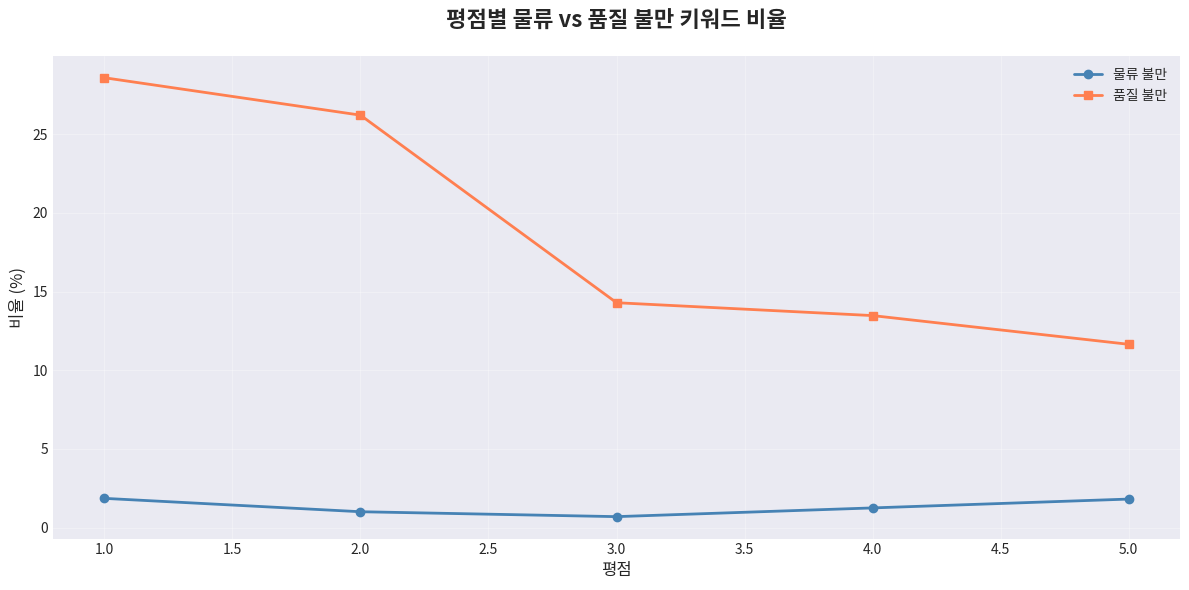

In [41]:
# 평점별 물류/품질불만 비율
fig, ax = plt.subplots(figsize=(12, 6))

x = df_by_rating['평점']
ax.plot(x, df_by_rating['물류_비율'], marker='o', linewidth=2, label='물류 불만', color='steelblue')
ax.plot(x, df_by_rating['품질불만_비율'], marker='s', linewidth=2, label='품질 불만', color='coral')

ax.set_xlabel('평점', fontsize=12)
ax.set_ylabel('비율 (%)', fontsize=12)
ax.set_title('평점별 물류 vs 품질 불만 키워드 비율', fontsize=16, fontweight='bold', pad=20)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
# 희소성 패턴 분석 (간소화 버전)
from keyword_analysis import print_scarcity_analysis

df_good_but_hard, stats = print_scarcity_analysis(
    df_reviews, 
    text_column='text',
    rating_column='rating',
    high_rating_threshold=4,
    n_samples=10,
    show_pattern_stats=True
)

[희소성 패턴 통계]
희소성 패턴 포함 리뷰: 4,397개 (2.2%)

[희소성 패턴 분석]
희소성 패턴 + 높은 평점(4-5점) 리뷰: 4,311개
전체 대비 비율: 2.2%
희소성 리뷰 중 높은 평점 비율: 98.0%

[샘플 리뷰]
1. (평점 4점) 나무면봉 말고
하얀색으로 구매 하고팠는데
상품이 없어서 이걸로...
2. (평점 5점) 재구매 품절대란인데 좋다고해서 구매해봅니다...
3. (평점 5점) 재구매 역시 유명한 것은 이유가 있다니까요.
리들샷은 너무 좋아요!!!!

다음에 또 재입고 뜨면 살게요><

다이소몰 생겨서 좋아요~~...
4. (평점 5점) 재구매 구하기 힘들엇는데 구매하게되서 좋아요 ㅎ...
5. (평점 5점) 재구매 구하기 힘들엇는데 구매하게되서 좋아요 ㅎ...
6. (평점 5점) 요즘 아주 핫한 아이템이라 구하기 힘들었어요
다이소 몰에서 운좋게 구매했네요
구매제한때문에 정해진 수량만 구입했어요...
7. (평점 5점) 재구매 드디어 구했네요. 다이소 갈때마다 품절이고 여기서도 품절이였는데 드디어 제 손에 들어왔네요.🤗
배송지연으로 조금 더 지다려야 했지만 많이 기대되고 설레네요.효과가 있었으면 좋겠습니다.

오늘 드디어 도착했네요.
어머님하고 둘이 발라봤는데 생각보다 자극은 없었어요...
8. (평점 5점) 재구매 리들샷 좋다고 그러길래 주문해봤는데
오늘 첫날 바른거라 좋은건 며칠 써봐야 알겠어요
정말 따꼼따꼼 거리긴하네요
약간 빨개지구요
지금 4시간지나서 건조하길래
크림 덧발랐는데도 바르면서 또 따꼼거려요
품절이 빨리 풀리면 좋겠어요...
9. (평점 5점) 재구매 드디어 구했네요. 다이소 갈때마다 품절이고 여기서도 품절이였는데 드디어 제 손에 들어왔네요.🤗
배송지연으로 조금 더 지다려야 했지만 많이 기대되고 설레네요.효과가 있었으면 좋겠습니다.

오늘 드디어 도착했네요.
어머님하고 둘이 발라봤는데 생각보다 자극은 없었어요...
10. (평점 5점) 재구매 드디어 구했네요. 다이소 갈때마다 품절이고 여기서도 품절이였는데 드

## 11. 인사이트 및 결론


In [43]:
# 핵심 인사이트 정리
insights = f"""
[RQ1 분석 결과: 재구매를 만드는 핵심 속성]

1. 재구매 비율
   - 전체 리뷰 중 재구매 리뷰: {(df_reviews["is_재구매"].sum() / len(df_reviews) * 100):.1f}%
   - 재구매 그룹 평균 평점: {df_repurchase["rating"].mean():.2f}점
   - 일반 그룹 평균 평점: {df_general["rating"].mean():.2f}점

2. 카테고리별 키워드 분석
   - 재구매 그룹 주요 카테고리: 품질[긍정], 품질[부정], 물류[부정]
   - 일반 그룹 주요 카테고리: 품질[긍정], 품질[부정], 편의[긍정]

3. 물류 vs 품질 불만
   - 물류 불만 리뷰: {(df_reviews["has_logistics"].sum() / len(df_reviews) * 100):.1f}%
   - 품질 불만 리뷰: {(df_reviews["has_quality_issue"].sum() / len(df_reviews) * 100):.1f}%
   - 희소성 패턴 (물류 불만 + 높은 평점): {stats["good_but_hard_ratio"]*100:.1f}%

4. 주요 발견
   - 재구매 그룹은 일반 그룹 대비 심미, 편의 키워드를 더 많이 언급
   - 높은 평점에서도 물류 불만 존재
   - "제품은 좋은데 구하기 힘들다"는 희소성 패턴이 존재

5. 비즈니스 시사점
   - 다이소는 "싸서 한번 사는 시장"이 아니라 "품질이 괜찮아서 계속 쓰는 시장"
   - 품질, 디자인, 편의성 강화가 재구매율 향상의 핵심
   - 물류 개선은 고객 만족도 향상에 필요하나, 재구매 결정 요인은 아님
"""

print(insights)


[RQ1 분석 결과: 재구매를 만드는 핵심 속성]

1. 재구매 비율
   - 전체 리뷰 중 재구매 리뷰: 34.1%
   - 재구매 그룹 평균 평점: 4.84점
   - 일반 그룹 평균 평점: 4.75점

2. 카테고리별 키워드 분석
   - 재구매 그룹 주요 카테고리: 품질[긍정], 품질[부정], 물류[부정]
   - 일반 그룹 주요 카테고리: 품질[긍정], 품질[부정], 편의[긍정]

3. 물류 vs 품질 불만
   - 물류 불만 리뷰: 1.7%
   - 품질 불만 리뷰: 12.1%
   - 희소성 패턴 (물류 불만 + 높은 평점): 2.2%

4. 주요 발견
   - 재구매 그룹은 일반 그룹 대비 심미, 편의 키워드를 더 많이 언급
   - 높은 평점에서도 물류 불만 존재
   - "제품은 좋은데 구하기 힘들다"는 희소성 패턴이 존재

5. 비즈니스 시사점
   - 다이소는 "싸서 한번 사는 시장"이 아니라 "품질이 괜찮아서 계속 쓰는 시장"
   - 품질, 디자인, 편의성 강화가 재구매율 향상의 핵심
   - 물류 개선은 고객 만족도 향상에 필요하나, 재구매 결정 요인은 아님



In [44]:
# 결과 저장
output_path = Path('./results_RQ1')
output_path.mkdir(exist_ok=True)

# 주요 결과 데이터프레임 저장
df_comparison.to_csv(output_path / 'keyword_comparison.csv', index=False, encoding='utf-8-sig')
df_cat_comparison.to_csv(output_path / 'category_comparison.csv', index=False, encoding='utf-8-sig')

# 인사이트 텍스트 저장
with open(output_path / 'insights_RQ1.txt', 'w', encoding='utf-8') as f:
    f.write(insights)

print(f"[완료] 결과 저장: {output_path}")

[완료] 결과 저장: results_RQ1
